In [ ]:
!pip install -q datasets transformers sentencepiece

     |████████████████████████████████| 365 kB 10.3 MB/s 
     |████████████████████████████████| 4.7 MB 42.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.5 MB/s 
     |████████████████████████████████| 101 kB 7.3 MB/s 
     |████████████████████████████████| 212 kB 21.2 MB/s 
     |████████████████████████████████| 141 kB 9.1 MB/s 
     |████████████████████████████████| 115 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 127 kB 9.2 MB/s 
     |████████████████████████████████| 6.6 MB 11.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict
import os
import random
import regex as re
import logging
import gc
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import XLMRobertaTokenizer
from transformers.models.xlm_roberta.modeling_xlm_roberta import  XLMRobertaModel, XLMRobertaConfig
from transformers import BertConfig, BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [ ]:
dataset = DatasetDict()
dataset['train'] = load_dataset('glue', 'mrpc', split='train')
dataset['test'] = load_dataset('glue', 'mrpc', split='test')

08/05/2022 14:01:48 - WARNING - datasets.builder -   Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
08/05/2022 14:01:48 - WARNING - datasets.builder -   Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
dataset['train']

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

In [ ]:
# from torch.utils.data import Subset
# dataset['train'] = dataset['train'].shuffle(seed=42)
# dataset['train'] = Subset(dataset["train"], list(range(380)))

In [ ]:
Paraphrase_Forgettables_Info = pd.read_csv('/content/Paraphrase_Forgettables_Info.csv')
Paraphrase_Forgettables_Info

,Unnamed: 0,sample_index,forgetting_events,True_label_indexes
0,0,1,1,[0 5 6 7 8 9]
1,1,5,2,[0 4 6 7 8 9]
2,2,6,1,[1 2 4 5 6 7 8 9]
3,3,9,2,[0 2 4 5 6 7 8 9]
4,4,24,1,[0 3 4 5 6 7 8 9]
...,...,...,...,...
375,375,3570,1,[1 3 4 5 6 7 8 9]
376,376,3603,1,[0 2 3 4 5 6 7 8 9]
377,377,3624,1,[0 1 2 3 4 6 7 8 9]
378,378,3651,1,[0 1 3 4 5 6 7 8 9]


In [ ]:
dataset['train'] = Dataset.from_pandas(pd.DataFrame.from_dict([dataset['train'][idx] for idx in Paraphrase_Forgettables_Info['sample_index']]))
dataset['train']

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 380
})

{0: 0.40105540897097625, 1: 0.6015831134564644}

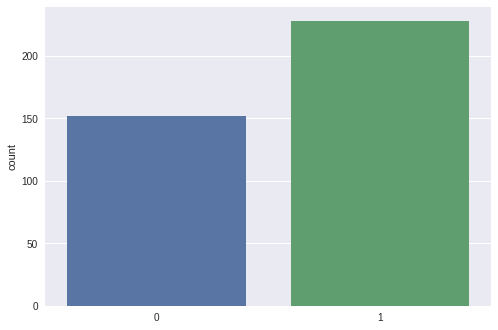

In [ ]:
freq_dict = dict()
for data in dataset['train']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['train']) - 1)

sns.countplot(x=dataset['train']['label'])
freq_dict

{0: 0.3354614045269878, 1: 0.665699361578642}

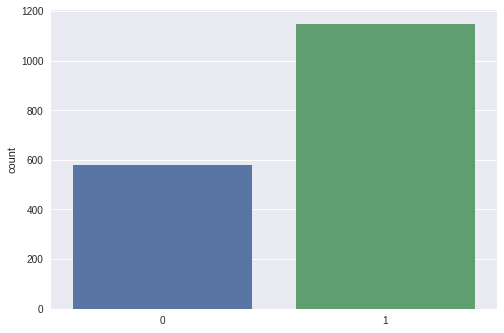

In [ ]:
freq_dict = dict()
for data in dataset['test']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['test']) - 2)

sns.countplot(x=dataset['test']['label'])
freq_dict

In [ ]:
class Textual_EntailementClassifier(nn.Module):
    def __init__(self, input_dim, num_labels=3, dropout_rate=0.):
        super(Textual_EntailementClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(input_dim, input_dim // 3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(input_dim // 3, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        return self.linear2(x)

In [ ]:
class BERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(BERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.bert = BertModel(config=config) # Load pretrained Bert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
class ParsBERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(ParsBERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.parsbert = BertModel(config=config) # Load pretrained ParsBert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.parsbert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
MODEL_CLASSES = {
    'bert': (BertConfig, BERT_Textual_Entailement, BertTokenizer),
    'parsbert': (BertConfig, ParsBERT_Textual_Entailement, BertTokenizer),
}

MODEL_PATH_MAP = {
    # 'XLMRoberta': 'xlm-roberta-base',
    'bert': 'bert-base-uncased',
    'parsbert': 'HooshvareLab/bert-fa-zwnj-base',
}

logger = logging.getLogger(__name__)

In [ ]:
def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)

def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)
    
def label2index(label):
    if (label == 'neutral'): return 0
    elif (label == 'entails'): return 1
    # else: return 2
    else: return label

def get_labels(dataset):
  train_label = list()
  for data in dataset:
      if (data['label'] != 'xx' and data['label'] != '-'): train_label.append(data['label'])
  
  return train_label

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def prepare_dataset(data, args, tokenizer, padding='max_length'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_label = torch.tensor([label2index(x['label']) for x in data if  (x['label'] != 'xx' and x['label'] != '-')], dtype=torch.long).to(device)
    bert_input = tokenizer([x['sentence1'] for x in data if (x['label'] != 'xx' and x['label'] != '-')] , [x['sentence2'] for x in data if (x['label'] != 'xx' and x['label'] != '-')], padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
    if ('token_type_ids' in bert_input):
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), bert_input['token_type_ids'].to(device), all_label)
    else:
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), torch.zeros_like(bert_input['input_ids']).to(device), all_label)

    return dataset

In [ ]:
#define
OUTPUT_DIM = 2
NUM_EPOCHS = 10
Prob_per_epoch = np.zeros((NUM_EPOCHS,len(dataset['train']),OUTPUT_DIM)) #2 labels

class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(dataset['train'])

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]
        self.config = self.config_class.from_pretrained(args.model_name_or_path, finetuning_task=args.task)
        self.model = self.model_class.from_pretrained(args.model_name_or_path,
                                                      config=self.config,
                                                      args=args,
                                                      label_lst=self.label_lst)
                                                      

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

    def train(self):
        # train_sampler = RandomSampler(self.train_dataset)
        train_sampler = SequentialSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)
        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()
        best_acc = -1
       
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")
        for epoch in train_iterator:
            label_preds = None
            out_label_ids = None
            # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
            stacked_train_preds = None
            for step, batch in enumerate(train_dataloader):
                self.model.train()
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                loss = outputs[0]
                label_logits = outputs[1]

                # ############## Extracting samples'probability ##############
                # # Get the preds
                preds = nn.Softmax(dim=1)(label_logits) # convert to probability


                # # Move preds to the CPU
                train_preds = preds.detach().cpu().numpy()
                
                if stacked_train_preds is None:  # first batch
                    stacked_train_preds = train_preds
                else:
                  stacked_train_preds = np.vstack((stacked_train_preds, train_preds))
                
                # #######################  END ############################

                 # label prediction
                if label_preds is None:
                    label_preds = label_logits.detach().cpu().numpy()
                    out_label_ids = inputs['label_ids'].detach().cpu().numpy()
                else:
                    label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                    out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)
                
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if(global_step % 10 == 0): logger.info("Train loss = %.4f", tr_loss / global_step)
                    if (self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0):
                        results = self.evaluate("dev")
                        if (float(results['accuracy']) > best_acc):
                        # if (float(results['slot_f1']) > best_f1):
                        #   best_f1 = float(results['slot_f1'])
                          best_acc = float(results['accuracy'])
                          logger.info("dev best_acc = %.4f", best_acc * 100.0)
                          self.save_model()

                   
            Prob_per_epoch[epoch][:,:] = stacked_train_preds
            
            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break
            
            # label result
            label_preds = np.argmax(label_preds, axis=1)
            logger.info("train_acc = %.4f", accuracy_score(out_label_ids, label_preds) * 100.0)


        return global_step, tr_loss / global_step

    def evaluate(self, mode):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("\n***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        label_preds = None
        out_label_ids = None

        self.model.eval()

        # for batch in tqdm(eval_dataloader, desc="Evaluating"):
        for batch in eval_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                tmp_eval_loss, label_logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
            
            nb_eval_steps += 1

            # label prediction
            if label_preds is None:
                label_preds = label_logits.detach().cpu().numpy()
                out_label_ids = inputs['label_ids'].detach().cpu().numpy()
            else:
                label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)


        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # label result
        label_preds = np.argmax(label_preds, axis=1)
        print(set(label_preds))
        total_result = accuracy_score(out_label_ids, label_preds)
        results.update({'accuracy' : total_result})
        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %.4f", key if key != 'loss' else 'loss', float(results[key]) * 100.0 if key != 'loss' else float(results[key]))

        if (mode == 'test'): print(classification_report(out_label_ids, label_preds, target_names=['neutral', 'entails'], digits = 4))
        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)


    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir,
                                                          args=self.args,
                                                          label_lst=self.label_lst)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")


In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

Using bert


In [ ]:
args = dotdict(dict())
args.seed = 810197502
args.model_type = 'bert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.dropout_rate =  0.3
args.do_train = True
args.do_eval = True
args.train_batch_size = 32 
args.max_steps = -1
args.task = 'Paraphrase' 
args.no_cuda = False
args.weight_decay = 0
args.num_train_epochs = NUM_EPOCHS
args.gradient_accumulation_steps = 1
args.learning_rate = 3e-5 
args.adam_epsilon = 1e-8
args.warmup_steps = 0 
args.logging_steps = 200
args.save_steps = 500
args.max_grad_norm = 1
args.eval_batch_size = 64
args.model_dir = "Paraphrase_model_" + args.model_type
args.max_seq_len = 128


In [ ]:
init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
train_dataset = prepare_dataset(dataset['train'], args, tokenizer)
# valid_dataset = prepare_dataset(dataset['validation'], args, tokenizer)
test_dataset = prepare_dataset(dataset['test'], args, tokenizer)
valid_dataset = test_dataset

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BERT_Textual_Entailement: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BERT_Textual_Entailement were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# all
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 14:04:56 - INFO - __main__ -   ***** Running training *****
08/05/2022 14:04:56 - INFO - __main__ -     Num examples = 3668
08/05/2022 14:04:56 - INFO - __main__ -     Num Epochs = 10
08/05/2022 14:04:56 - INFO - __main__ -     Total train batch size = 32
08/05/2022 14:04:56 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 14:04:56 - INFO - __main__ -     Total optimization steps = 1150
08/05/2022 14:04:56 - INFO - __main__ -     Logging steps = 200
08/05/2022 14:04:56 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 14:05:03 - INFO - __main__ -   Train loss = 0.6627
08/05/2022 14:05:10 - INFO - __main__ -  

{0, 1}


08/05/2022 14:07:33 - INFO - __main__ -   Train loss = 0.4688
08/05/2022 14:07:40 - INFO - __main__ -   Train loss = 0.4588
08/05/2022 14:07:47 - INFO - __main__ -   Train loss = 0.4485
08/05/2022 14:07:47 - INFO - __main__ -   train_acc = 86.8321
Epoch:  20%|██        | 2/10 [02:50<11:32, 86.54s/it]08/05/2022 14:07:53 - INFO - __main__ -   Train loss = 0.4391
08/05/2022 14:08:00 - INFO - __main__ -   Train loss = 0.4304
08/05/2022 14:08:07 - INFO - __main__ -   Train loss = 0.4211
08/05/2022 14:08:13 - INFO - __main__ -   Train loss = 0.4119
08/05/2022 14:08:20 - INFO - __main__ -   Train loss = 0.4075
08/05/2022 14:08:27 - INFO - __main__ -   Train loss = 0.4002
08/05/2022 14:08:33 - INFO - __main__ -   Train loss = 0.3927
08/05/2022 14:08:40 - INFO - __main__ -   Train loss = 0.3876
08/05/2022 14:08:47 - INFO - __main__ -   Train loss = 0.3801
08/05/2022 14:08:54 - INFO - __main__ -   Train loss = 0.3733
08/05/2022 14:09:00 - INFO - __main__ -   Train loss = 0.3649
08/05/2022 14:09:

{0, 1}


08/05/2022 14:10:00 - INFO - __main__ -   Train loss = 0.3226
08/05/2022 14:10:06 - INFO - __main__ -   Train loss = 0.3178
08/05/2022 14:10:13 - INFO - __main__ -   Train loss = 0.3128
08/05/2022 14:10:20 - INFO - __main__ -   Train loss = 0.3076
08/05/2022 14:10:27 - INFO - __main__ -   Train loss = 0.3024
08/05/2022 14:10:33 - INFO - __main__ -   Train loss = 0.2974
08/05/2022 14:10:33 - INFO - __main__ -   train_acc = 96.9466
Epoch:  40%|████      | 4/10 [05:36<08:30, 85.08s/it]08/05/2022 14:10:40 - INFO - __main__ -   Train loss = 0.2928
08/05/2022 14:10:46 - INFO - __main__ -   Train loss = 0.2891
08/05/2022 14:10:53 - INFO - __main__ -   Train loss = 0.2840
08/05/2022 14:11:00 - INFO - __main__ -   Train loss = 0.2792
08/05/2022 14:11:06 - INFO - __main__ -   Train loss = 0.2757
08/05/2022 14:11:13 - INFO - __main__ -   Train loss = 0.2709
08/05/2022 14:11:20 - INFO - __main__ -   Train loss = 0.2675
08/05/2022 14:11:27 - INFO - __main__ -   Train loss = 0.2645
08/05/2022 14:11:

{0, 1}


08/05/2022 14:12:29 - INFO - __main__ -   Train loss = 0.2395
08/05/2022 14:12:36 - INFO - __main__ -   Train loss = 0.2366
08/05/2022 14:12:43 - INFO - __main__ -   Train loss = 0.2332
08/05/2022 14:12:49 - INFO - __main__ -   Train loss = 0.2303
08/05/2022 14:12:56 - INFO - __main__ -   Train loss = 0.2272
08/05/2022 14:13:03 - INFO - __main__ -   Train loss = 0.2247
08/05/2022 14:13:09 - INFO - __main__ -   Train loss = 0.2220
08/05/2022 14:13:16 - INFO - __main__ -   Train loss = 0.2188
08/05/2022 14:13:23 - INFO - __main__ -   Train loss = 0.2160
08/05/2022 14:13:23 - INFO - __main__ -   train_acc = 99.1276
Epoch:  60%|██████    | 6/10 [08:26<05:43, 85.75s/it]08/05/2022 14:13:29 - INFO - __main__ -   Train loss = 0.2132
08/05/2022 14:13:36 - INFO - __main__ -   Train loss = 0.2109
08/05/2022 14:13:43 - INFO - __main__ -   Train loss = 0.2082
08/05/2022 14:13:49 - INFO - __main__ -   Train loss = 0.2059
08/05/2022 14:13:56 - INFO - __main__ -   Train loss = 0.2038
08/05/2022 14:14:

{0, 1}


08/05/2022 14:14:52 - INFO - __main__ -   train_acc = 99.3184
Epoch:  70%|███████   | 7/10 [09:56<04:21, 87.01s/it]08/05/2022 14:14:56 - INFO - __main__ -   Train loss = 0.1885
08/05/2022 14:15:02 - INFO - __main__ -   Train loss = 0.1868
08/05/2022 14:15:09 - INFO - __main__ -   Train loss = 0.1845
08/05/2022 14:15:16 - INFO - __main__ -   Train loss = 0.1826
08/05/2022 14:15:22 - INFO - __main__ -   Train loss = 0.1807
08/05/2022 14:15:29 - INFO - __main__ -   Train loss = 0.1787
08/05/2022 14:15:36 - INFO - __main__ -   Train loss = 0.1768
08/05/2022 14:15:42 - INFO - __main__ -   Train loss = 0.1750
08/05/2022 14:15:49 - INFO - __main__ -   Train loss = 0.1734
08/05/2022 14:15:56 - INFO - __main__ -   Train loss = 0.1717
08/05/2022 14:16:03 - INFO - __main__ -   Train loss = 0.1699
08/05/2022 14:16:09 - INFO - __main__ -   Train loss = 0.1681
08/05/2022 14:16:09 - INFO - __main__ -   train_acc = 99.5911
Epoch:  80%|████████  | 8/10 [11:12<02:47, 83.78s/it]08/05/2022 14:16:16 - INFO

{0, 1}


08/05/2022 14:17:22 - INFO - __main__ -   Train loss = 0.1546
08/05/2022 14:17:29 - INFO - __main__ -   Train loss = 0.1531
08/05/2022 14:17:36 - INFO - __main__ -   Train loss = 0.1516
08/05/2022 14:17:39 - INFO - __main__ -   train_acc = 99.7001
Epoch:  90%|█████████ | 9/10 [12:42<01:25, 85.60s/it]08/05/2022 14:17:42 - INFO - __main__ -   Train loss = 0.1502
08/05/2022 14:17:49 - INFO - __main__ -   Train loss = 0.1490
08/05/2022 14:17:55 - INFO - __main__ -   Train loss = 0.1478
08/05/2022 14:18:02 - INFO - __main__ -   Train loss = 0.1465
08/05/2022 14:18:09 - INFO - __main__ -   Train loss = 0.1454
08/05/2022 14:18:15 - INFO - __main__ -   Train loss = 0.1440
08/05/2022 14:18:22 - INFO - __main__ -   Train loss = 0.1428
08/05/2022 14:18:29 - INFO - __main__ -   Train loss = 0.1415
08/05/2022 14:18:36 - INFO - __main__ -   Train loss = 0.1404
08/05/2022 14:18:42 - INFO - __main__ -   Train loss = 0.1392
08/05/2022 14:18:49 - INFO - __main__ -   Train loss = 0.1380
08/05/2022 14:18:

{0, 1}
              precision    recall  f1-score   support

     neutral     0.7941    0.7007    0.7445       578
     entails     0.8576    0.9085    0.8823      1147

    accuracy                         0.8388      1725
   macro avg     0.8259    0.8046    0.8134      1725
weighted avg     0.8363    0.8388    0.8361      1725



In [ ]:
# random
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 13:59:34 - INFO - __main__ -   ***** Running training *****
08/05/2022 13:59:34 - INFO - __main__ -     Num examples = 380
08/05/2022 13:59:34 - INFO - __main__ -     Num Epochs = 10
08/05/2022 13:59:34 - INFO - __main__ -     Total train batch size = 32
08/05/2022 13:59:34 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 13:59:34 - INFO - __main__ -     Total optimization steps = 120
08/05/2022 13:59:34 - INFO - __main__ -     Logging steps = 200
08/05/2022 13:59:34 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 13:59:43 - INFO - __main__ -   Train loss = 0.6657
08/05/2022 13:59:44 - INFO - __main__ -   t

{0, 1}
              precision    recall  f1-score   support

     neutral     0.6090    0.3962    0.4801       578
     entails     0.7413    0.8718    0.8013      1147

    accuracy                         0.7125      1725
   macro avg     0.6752    0.6340    0.6407      1725
weighted avg     0.6970    0.7125    0.6937      1725



In [ ]:
# forgetable
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 13:09:28 - INFO - __main__ -   ***** Running training *****
08/05/2022 13:09:28 - INFO - __main__ -     Num examples = 380
08/05/2022 13:09:28 - INFO - __main__ -     Num Epochs = 10
08/05/2022 13:09:28 - INFO - __main__ -     Total train batch size = 32
08/05/2022 13:09:28 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 13:09:28 - INFO - __main__ -     Total optimization steps = 120
08/05/2022 13:09:28 - INFO - __main__ -     Logging steps = 200
08/05/2022 13:09:28 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 13:09:37 - INFO - __main__ -   Train loss = 0.6716
08/05/2022 13:09:38 - INFO - __main__ -   t

{0, 1}
              precision    recall  f1-score   support

     neutral     0.3930    0.3114    0.3475       578
     entails     0.6859    0.7576    0.7200      1147

    accuracy                         0.6081      1725
   macro avg     0.5394    0.5345    0.5337      1725
weighted avg     0.5877    0.6081    0.5952      1725



In [ ]:
Prob_per_epoch.shape

(10, 380, 2)

In [ ]:
import pickle
with open(f'Paraphrase_prob_per_{NUM_EPOCHS}epochs.pkl', 'wb') as f:
    data = pickle.dump(Prob_per_epoch, f)

In [ ]:
!pip install -q datasets

In [ ]:
import numpy as np


with open('Paraphrase_prob_per_10epochs.pkl', 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
from datasets import load_dataset

dataset = load_dataset('glue','mrpc')

In [ ]:
def extract_forgettable_samples(prob_arr,true_label):
  forgettable_info = {'sample_index':[],'forgetting_events':[],'True_label_indexes':[]}
  for i in range(prob_arr.shape[1]):
    forgetting_events = 0
    prob_per_sample = prob_arr[:,i,:]
    label_per_sample = np.argmax(prob_per_sample,axis=1)
    true_label_indexs = np.where(label_per_sample == true_label[i])[0]

    for item in (true_label_indexs + 1):
      if item not in true_label_indexs and item < prob_arr.shape[0]:
          forgetting_events += 1
    if forgetting_events > 0:
      forgettable_info['sample_index'].append(i)
      forgettable_info['forgetting_events'].append(forgetting_events)
      forgettable_info['True_label_indexes'].append(true_label_indexs)
    else:
      continue

  return forgettable_info
    

In [ ]:
true_label = dataset['train']['label'] # Labels should be numerical 
prob_arr = data
F_info = extract_forgettable_samples(prob_arr,true_label)

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(F_info)

In [ ]:
data.shape[1]

In [ ]:
# # Save the model to drive
# !cp /content/Textual_Entailement_model/pytorch_model.bin /content/drive/MyDrive/Textual_Entailement_model
# !cp /content/Textual_Entailement_model/config.json /content/drive/MyDrive/Textual_Entailement_model